In [93]:
#%% Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import skimage.io

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans

import annotation, image_render, hyspec_io

In [2]:
# Paths
hyspec_file_Rrs = '/media/mha114/MassimalDataProcessing/20210418_Juvika/Transect1-15m-AGL/R_rs/manual_Pika_L_13-14-radiance-AppendCube-SpatialCrop-ReflectivityConversionFromRadiance.bip.hdr'
annotation_json = '/media/mha114/MassimalDataProcessing/20210418_Juvika/Annotation/20210418_Juvika_Transects_V3/label_classes.json'
annotation_png = '/media/mha114/MassimalDataProcessing/20210418_Juvika/Annotation/20210418_Juvika_Transects_V3/transect1_15mAGL_rgb.png'

In [3]:
# Read hyperspectral file
(im,wl,rgb_ind,metadata) = hyspec_io.load_envi_image(hyspec_file_Rrs)

In [4]:
# Limit data to visible range
vis_wl = wl < 750
im = im[:,:,vis_wl]
(nLines,nSamp,nWl) = im.shape

In [5]:
# Read annotation
class_dict = annotation.read_hasty_metadata(annotation_json)
annotation_mask = np.flip(skimage.io.imread(annotation_png),(0,1)) # Annotation image is flipped, flip back

In [6]:
#%% Print class dictionary
print('Class : Index \n')
for key,value in class_dict.items():
    print(key + ' : ' + str(value))

Class : Index 

Seagrass-0-25%-density : 1
Seagrass-25-50%-density : 2
Fucus-vesiculosus : 3
Ascophyllum-nodosum : 4
Sand : 5
White-rope : 6
Bamboo-stick : 7
Blue-marker : 8
Yellow-marker : 9
Gray-reference : 10
Black-reference : 11
Shadow : 12


In [7]:
#%% Create filtered/simplified list of classes to use in classification
classes_used = ['Sand',
                'Seagrass-0-25%-density',
                'Seagrass-25-50%-density',
                'Ascophyllum-nodosum',
                'Fucus-vesiculosus']

In [8]:
#%% Create class map with only selected (used) classes
class_mask_simple = np.zeros(annotation_mask.shape)
for ii,name in enumerate(classes_used):
    class_mask_simple[annotation_mask == class_dict[name]] = ii+1

In [9]:
# Create masks for seagrass only
seagrass_mask = (class_mask_simple==2) | (class_mask_simple==3)

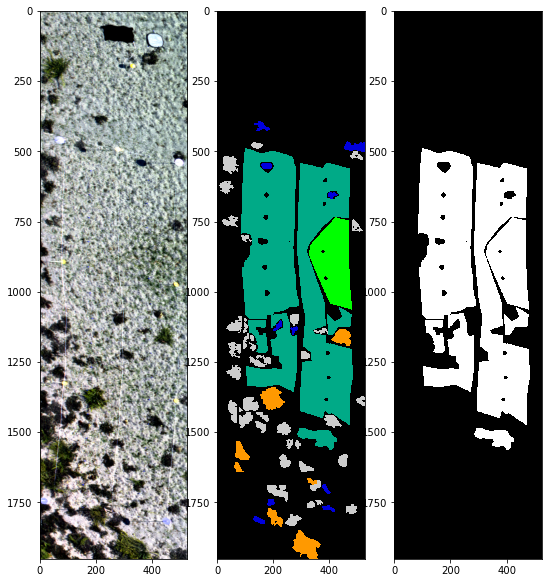

In [10]:
# Show RGB render of hyperspetral image, vegetation annotation mask, and seagrass mask
fig,ax = plt.subplots(ncols=3,figsize=(9,12))
ax[0].imshow(image_render.percentile_stretch(im[:,:,rgb_ind]))
ax[1].imshow(class_mask_simple,interpolation='none',cmap='nipy_spectral')
ax[2].imshow(seagrass_mask,interpolation='none',cmap='gray')

plt.show()

In [75]:
# Extract all annotated spectra (not background), implicit transformation to 2D matrix
# X_im = im[class_mask_simple>0]
X_im = im[seagrass_mask]
X_im.shape

(279484, 115)

In [228]:
# PCA
cluster_scaler = StandardScaler()
X_im_n = cluster_scaler.fit_transform(X_im)

# pca = PCA(n_components=15)
pca = PCA(n_components=5)
X_im_pca = pca.fit_transform(X_im_n)

make_pipeline()

ValueError: not enough values to unpack (expected 2, got 0)

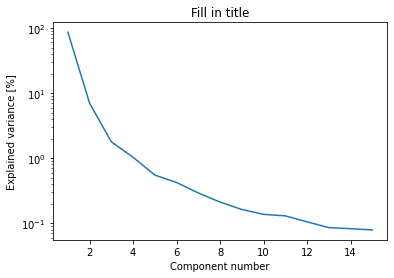

In [86]:
#%% Plot explained variance
plt.yscale("log")
plt.plot(np.arange(pca.n_components)+1, pca.explained_variance_ratio_*100)
plt.xlabel('Component number')
plt.ylabel('Explained variance [%]')
plt.title('Fill in title')
plt.show()

In [87]:
# Calculate the total explained variance
print('The total explained variance is ' + str(np.sum(pca.explained_variance_ratio_)*100) + ' %')

The total explained variance is 98.11754004264384 %


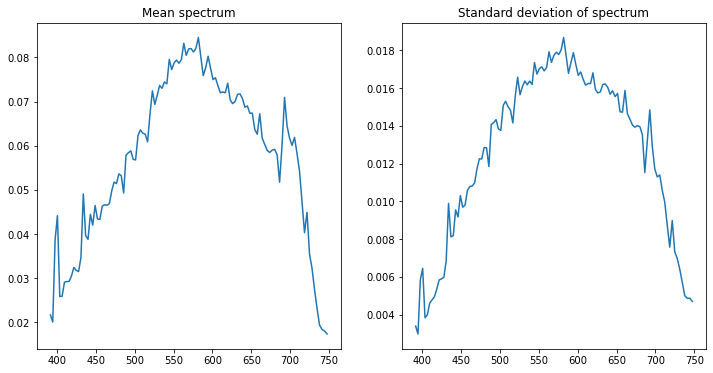

In [88]:
# Plot the mean spectrum and standard deviation used to center and normalize the data before PCA
fig,ax = plt.subplots(ncols=2,figsize=(12,6))
ax[0].plot(wl[vis_wl],cluster_scaler.mean_)
ax[0].set_title('Mean spectrum')
ax[1].plot(wl[vis_wl],cluster_scaler.scale_)
ax[1].set_title('Standard deviation of spectrum')
plt.show()

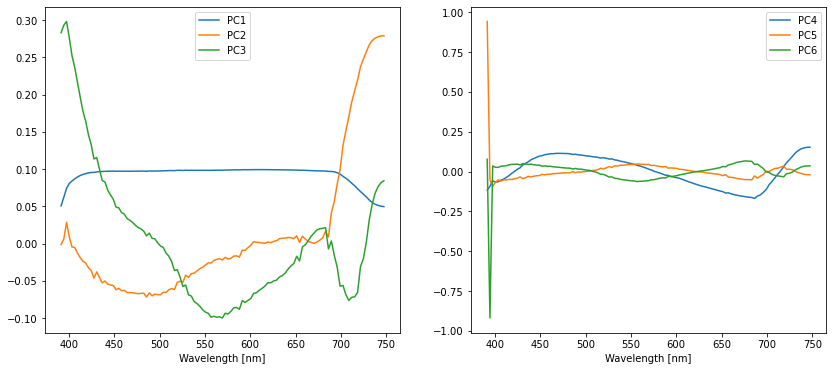

In [89]:
#%% Plot first components vs. wavelength
fig,ax = plt.subplots(ncols=2,figsize=(14,6))
ax[0].plot(wl[vis_wl],pca.components_[0,:],label='PC1')
ax[0].plot(wl[vis_wl],pca.components_[1,:],label='PC2')
ax[0].plot(wl[vis_wl],pca.components_[2,:],label='PC3')
ax[0].set_xlabel('Wavelength [nm]')
ax[0].legend()

ax[1].plot(wl[vis_wl],pca.components_[3,:],label='PC4')
ax[1].plot(wl[vis_wl],pca.components_[4,:],label='PC5')
ax[1].plot(wl[vis_wl],pca.components_[5,:],label='PC6')
ax[1].set_xlabel('Wavelength [nm]')
ax[1].legend()

plt.show()

(comments only valid if using all annotated data)
The plots of the two first components can, to some degree, be given a physical interpretation. 
* PC1 clearly shows the "red edge" around 700 nm
* PC2 also shows this edge, but also clearly has three small peaks easily recognizable from spectra of Fucus and Ascophyllum.

In [124]:
# Apply trained PCA model to whole image
im_veg = im
# im_veg[class_mask_simple == 0] = 0
im_veg[seagrass_mask == 0] = 0
im_pca = pca.transform(cluster_scaler.transform( np.reshape(im_veg,(-1,im.shape[2]))))

In [125]:
im_pca = np.reshape(im_pca,(im.shape[0],im.shape[1],-1))
im_pca.shape

(1951, 526, 15)

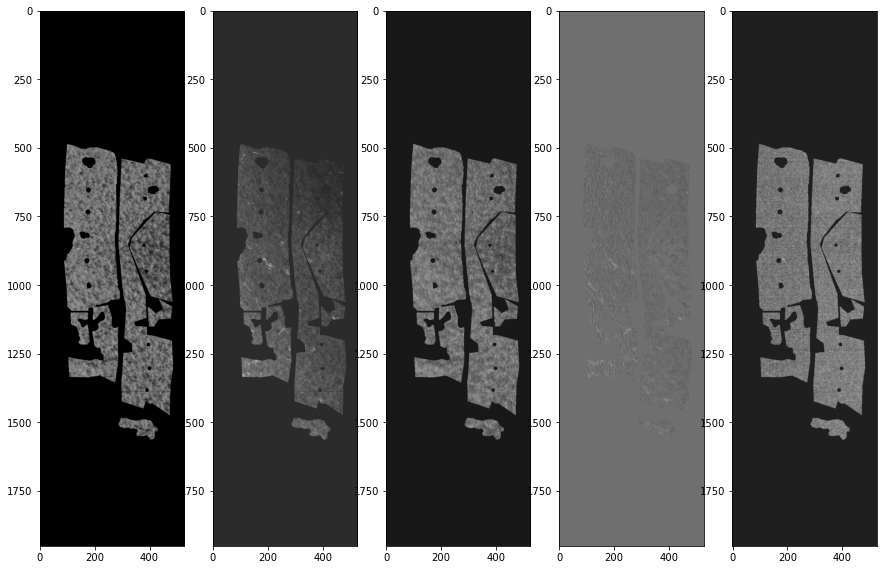

In [126]:
# Plot PCA components as images
fig,ax = plt.subplots(ncols=5,figsize=(15,12))
ax[0].imshow(im_pca[:,:,0],cmap='gray')
ax[1].imshow(im_pca[:,:,1],cmap='gray')
ax[2].imshow(im_pca[:,:,2],cmap='gray')
ax[3].imshow(im_pca[:,:,3],cmap='gray')
ax[4].imshow(im_pca[:,:,4],cmap='gray')

#ax[0].imshow(image_render.percentile_stretch(im[:,:,rgb_ind]))
#ax[1].imshow(image_render.percentile_stretch(im_pca[:,:,0:3]))

plt.show()

The three first components can (maybe) be interpreted in the following manner:
* PC1 corresponds to average reflectance (approximately)
* PC2 corresponds to a gradient in water depth
* PC3 corresponds to sand vs seagrass...?

(comments below only valid if using all annotated data)
These plots of PCA components can be interpreted, too:
* PC1 seems to distinguish beetween sand (high values) and vegetation (low values)
* PC2 and PC3 seems to be high for some macroalgae (probably Ascophyllum), perhaps those that are floating in the surface and thus are reflecting red and infrared light.
* PC4 seems to be high for macroalgae and/or 

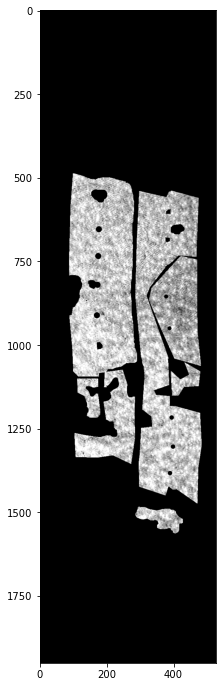

In [204]:
fig,ax = plt.subplots(ncols=1,figsize=(6,12))
tmp = np.expand_dims(im_pca[:,:,2],axis=2)
ax.imshow(image_render.percentile_stretch(tmp),cmap='gray')

In [205]:
# Try clustering
n_comp_clust = 3
# kmeans = KMeans(n_clusters=2,random_state=0).fit(X_im_pca[:,0:n_comp_clust])
kmeans = KMeans(n_clusters=2,random_state=0).fit(X_im_pca)

# kmeans = KMeans(n_clusters=2).fit(X_im_pca[:,1:(n_comp_clust+1)])

In [206]:
kmeans.cluster_centers_

array([[-9.6563749e+00,  1.5493805e-02,  1.5299489e-02, -1.3291973e-02,
         1.4187794e-03,  1.0529578e-04,  1.1241140e-03,  3.9680041e-03,
        -3.2363085e-03,  2.2108662e-03, -1.9311042e-04,  1.3963932e-03,
         1.2182449e-03,  2.6849832e-04,  1.7436987e-04],
       [ 6.8252707e+00, -1.0934731e-02, -1.0795169e-02,  9.3943961e-03,
        -9.5190038e-04, -6.6937646e-05, -7.8672369e-04, -2.8082905e-03,
         2.2903713e-03, -1.5647168e-03,  1.3849209e-04, -9.8940195e-04,
        -8.5606280e-04, -2.1880638e-04, -1.0259850e-04]], dtype=float32)

In [207]:
# Cluster training data
# labels = kmeans.predict(X_im_pca[:,0:n_comp_clust])
labels = kmeans.predict(X_im_pca)

# labels = kmeans.predict(X_im_pca[:,1:(n_comp_clust+1)])

In [208]:
print ('Label 0: ' + str(np.count_nonzero(labels == 0)) + ' pixels')
print ('Label 1: ' + str(np.count_nonzero(labels == 1)) + ' pixels')

Label 0: 115564 pixels
Label 1: 163920 pixels


In [209]:
# im_clust = kmeans.predict(np.reshape(im_pca[:,:,0:n_comp_clust],(-1,n_comp_clust)))
im_clust = kmeans.predict(np.reshape(im_pca,(-1,im_pca.shape[2])))

# im_clust = kmeans.predict(np.reshape(im_pca[:,:,1:(n_comp_clust+1)],(-1,n_comp_clust)))

In [210]:
np.count_nonzero(im_clust == 0)

862306

In [211]:
im_clust = np.reshape(im_clust,(im.shape[0],im.shape[1]))

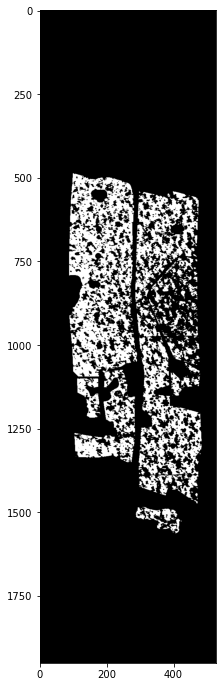

In [212]:
fig,ax = plt.subplots(ncols=1,figsize=(6,12))
ax.imshow(im_clust,cmap='gray')
#ax[1].imshow(im_clust[:,:,1],cmap='gray')


In [213]:
seagrass_cluster = seagrass_mask & (im_clust == 0)
sand_cluster = seagrass_mask & (im_clust == 1)

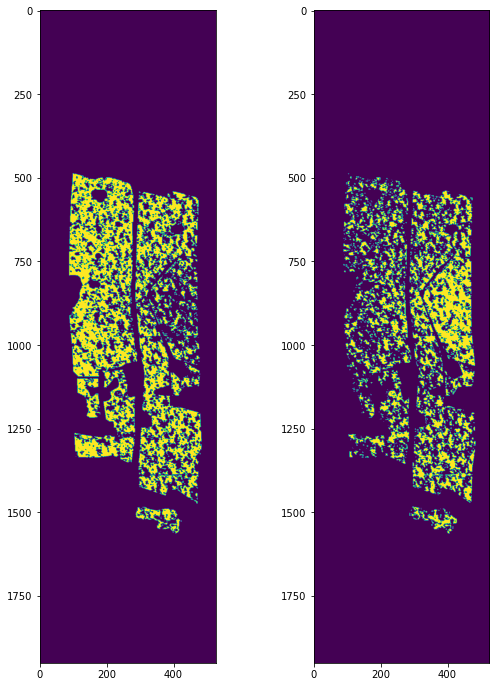

In [214]:
fig,ax = plt.subplots(ncols=2,figsize=(9,12))
ax[0].imshow(sand_cluster)
ax[1].imshow(seagrass_cluster)

plt.show()

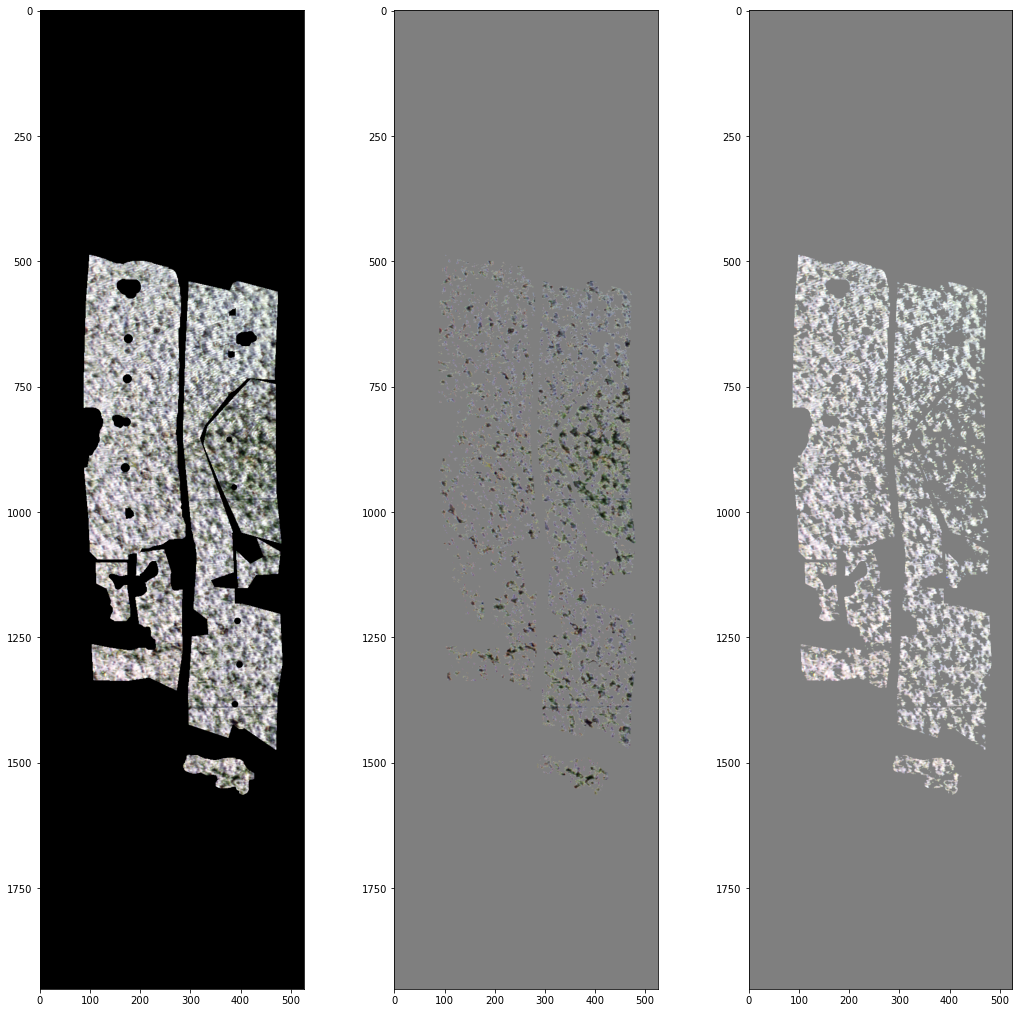

In [215]:
fig,ax = plt.subplots(ncols=3,figsize=(18,18))
rgb_im = image_render.percentile_stretch(im[:,:,rgb_ind], percentiles=(0,98))

seagrass_rgb_im = np.ones(rgb_im.shape)*0.5
seagrass_rgb_im[seagrass_cluster] = rgb_im[seagrass_cluster]

sand_rgb_im = np.ones(rgb_im.shape)*0.5
sand_rgb_im[sand_cluster] = rgb_im[sand_cluster]


ax[0].imshow(rgb_im)
ax[1].imshow(seagrass_rgb_im)
ax[2].imshow(sand_rgb_im)

#ax[2].imshow(rgb_im* np.expand_dims(sand_cluster,axis=2))

# ax[1].imshow(rgb_im* (np.expand_dims(seagrass_cluster,axis=2)*0.5 + 0.5))
# ax[2].imshow(rgb_im* (np.expand_dims(sand_cluster,axis=2)*0.5 + 0.5))

plt.show()

Clustering shows a clear pattern of dark pixels vs bright pixels. However, within the bright pixels (assumed to be sand) there is still some green, indicating that this cluster also contains some seagrass. Could try cutting out the first component (which seems to both be very dominant and also mainly represents an overall baseline shift in intensity. Alternatively, normalize the scores to reduce the influence of the first component.

In [216]:
seagrass_spec_mean = np.mean(im[seagrass_cluster],axis=0)
seagrass_spec_std = np.std(im[seagrass_cluster],axis=0)

sand_spec_mean = np.mean(im[sand_cluster],axis=0)
sand_spec_std = np.std(im[sand_cluster],axis=0)

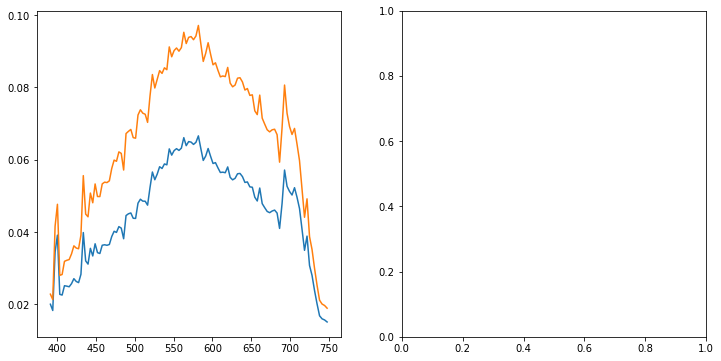

In [217]:
fig,ax = plt.subplots(ncols=2,figsize=(12,6))
ax[0].plot(wl[vis_wl],seagrass_spec_mean)
ax[0].plot(wl[vis_wl],sand_spec_mean)
plt.show()

In [226]:
new_class_map = np.zeros(class_mask_simple.shape)
new_class_map[(class_mask_simple == 1) | sand_cluster] = 1  # Sand = 1
new_class_map[seagrass_cluster] = 2
new_class_map[class_mask_simple == 4] = 3
new_class_map[class_mask_simple == 5] = 4

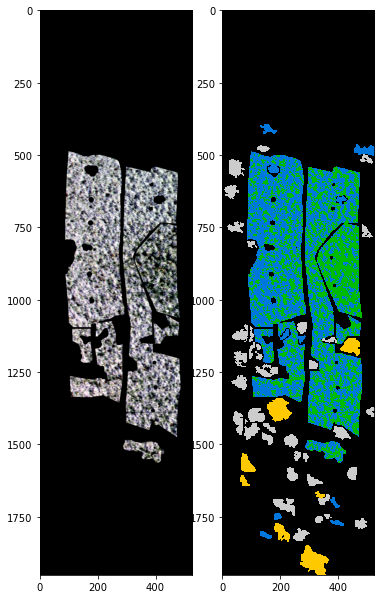

In [227]:
# Show RGB render of hyperspetral image, vegetation annotation mask, and seagrass mask
fig,ax = plt.subplots(ncols=2,figsize=(6,12))
ax[0].imshow(image_render.percentile_stretch(im[:,:,rgb_ind]))
ax[1].imshow(new_class_map,interpolation='none',cmap='nipy_spectral')

plt.show()